# M4B 판매데이터 시각화 분석 고급응용
- 실전적인 판매데이터 고급분석 - 고객분석
- 실전적인 판매데이터 고급분석 - 상품분석(외부데이터 결합분석)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

def zrmx_scl(vec):
    vec = vec/vec.max()
    return(vec)


import warnings
warnings.filterwarnings('ignore')


# local data path
dataPath = 'D:/YONG/myPydata/' # 데이터 위치는 사용자 지정


import matplotlib.font_manager

# matplotlib 에서 한글을 표시하기 위한 설정
font_name = matplotlib.font_manager.FontProperties(
                fname="c:/Windows/Fonts/malgun.ttf"  # 윈도우즈의 한글 폰트 위치를 지정
            ).get_name()
matplotlib.rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False #  음수를 나타내는 '-' 부호가 정상 표시되도록


### 데이터 불러오기

In [2]:
# 상품 테이블 불러오기
itemmast = pd.read_csv(dataPath + 'brk_itemmast01.csv', encoding='euc-kr')
itemmast = itemmast.drop(itemmast.columns[0], axis=1)


# 판매내역 테이블 불러오기
sales = pd.read_csv(dataPath + 'brk_salesmast01.csv', encoding='euc-kr')
sales = sales.drop(sales.columns[0], axis=1)


# 고객 테이블 불러오기
custmast = pd.read_csv(dataPath + 'brk_custmast01.csv', encoding='euc-kr')
custmast = custmast.drop(custmast.columns[0], axis=1)



## 실전적인 판매데이터 고급분석 예제 - 고객분석

### [예제1] 구매패턴에 고객유형별로 계절적 차이가 있는가?

In [3]:
# 월별 구매고객수 패턴 파악

# 월별 구매고객 테이블 생성
sales01 = sales[['cust_id', 'datea']].drop_duplicates()
sales01['saleMonth'] = sales01.datea.str.slice(0,7)
sales01 = sales01[['cust_id', 'saleMonth']].drop_duplicates()
sales01 = sales01[~sales01.cust_id.isna()]
sales01.sample(10).sort_values('saleMonth')

,cust_id,saleMonth
8636,B100077967,2019-02
6771,B100095079,2020-01
32666,B100038716,2020-02
26695,B100043005,2020-02
27421,B100033706,2020-02
36463,B100039440,2020-05
34974,B100013506,2020-07
27954,B100046195,2020-09
20749,B100097429,2020-10
11768,B100092792,2020-12


In [4]:
# 월별 고객수 집계 생성
# 동일 월에 동일 고객 복수 구매가 있어도 한 건으로 계산

dfmonCusts = sales01.groupby('saleMonth').count().reset_index()
display(dfmonCusts.tail())

,saleMonth,cust_id
19,2020-08,799
20,2020-09,1306
21,2020-10,765
22,2020-11,1721
23,2020-12,1699


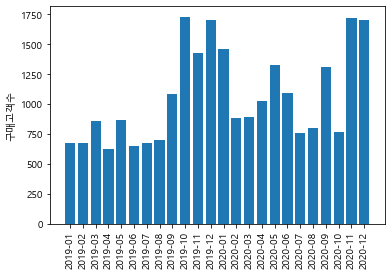

In [5]:
# 고객수 추이 시각화

plt.bar(dfmonCusts.saleMonth, dfmonCusts.cust_id)
plt.xticks(rotation=90)
plt.ylabel('구매고객수')
plt.show()

In [6]:
# 연도를 무시하고 월만 기준으로 집계

sales01['month_flag'] = sales01.saleMonth.str.slice(5,7)
sales01

,cust_id,saleMonth,month_flag
0,B100048542,2019-10,10
1,B100026268,2019-10,10
2,B100009871,2019-01,01
3,B100051628,2019-09,09
5,B100075455,2019-10,10
...,...,...,...
41928,B100063572,2020-11,11
41931,B100044469,2020-10,10
41933,B100044222,2020-10,10
41934,B100013999,2020-12,12


In [7]:
# 월별 고객수 집계 생성
# 동일 연월에 동일 고객 복수 구매가 있어도 한 건으로 계산

dfmonCusts1 = sales01[['month_flag','cust_id']].groupby('month_flag').count().reset_index()
display(dfmonCusts1.tail())

,month_flag,cust_id
7,08,1495
8,09,2392
9,10,2495
10,11,3143
11,12,3399


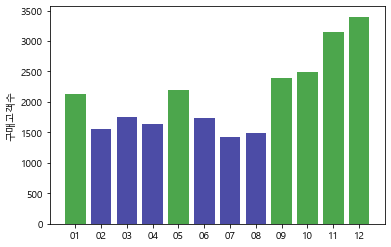

In [8]:
# 고객수 계절패턴 시각화 - 연도 무시

# 구매고객수가 많은 계절과 적은 계절을 색상으로 구별
colors1 = np.where(dfmonCusts1.cust_id>dfmonCusts1.cust_id.median(), 'green', 'navy')
plt.bar(dfmonCusts1.month_flag, dfmonCusts1.cust_id,
       color=colors1, alpha=0.7)
plt.ylabel('구매고객수')
plt.show()

- 12,11월 겨울 시즌 구매고객 많음
- 9,10,1,5월도 상대적으로 구매고객 많은 시즌

**[응용연습 : 다른 방식으로 처리해보기]** 
- 구매고객수가 많은 계절과 적은 계절을 색상으로 구별하기 위해
- 먼저 구매고객수가 중위수를 넘는지 여부를 나타내는 컬럼을 dfmonCusts1 데이터프레임에 추가
- 추가된 컬럼을 사용하여 막대 챠트에 색상 구분 표시

In [9]:
# 각 고객별로 가장 많이 구매한 월은?

dfcustMons = sales01.groupby(['cust_id','month_flag']).count().reset_index()
dfcustMons = dfcustMons.sort_values(['cust_id','saleMonth'], ascending=[False,False])
dfcustMons.tail(2000).head(10)

,cust_id,month_flag,saleMonth
1999,B100008039,09,1
2000,B100008039,12,1
1997,B100008024,03,1
1996,B100008019,11,1
1994,B100008017,04,1
1995,B100008017,07,1
1993,B100008014,04,1
1989,B100007997,06,2
1990,B100007997,08,2
1991,B100007997,09,1


In [10]:
# 고객별로 가장 많이 구매한 1개 월만 추출

dfcustMons1 = dfcustMons.groupby('cust_id').head(1)
dfcustMons1.head(800).tail()

,cust_id,month_flag,saleMonth
23502,B100094746,02,1
23500,B100094738,11,2
23494,B100094728,01,1
23493,B100094727,02,1
23492,B100094722,01,1


In [11]:
# 구매월 테이블에 고객의 성별, 연령 기본 속성 정보 결합

dfcustMons2 = dfcustMons1.merge(custmast[['cust_id','age','sex']], how='left', on='cust_id')
dfcustMons2

,cust_id,month_flag,saleMonth,age,sex
0,B100099990,04,1,40,F
1,B100099981,09,1,41,M
2,B100099976,11,1,29,F
3,B100099970,10,1,51,M
4,B100099964,02,1,42,F
...,...,...,...,...,...
15560,B100000037,07,1,41,M
15561,B100000023,05,1,27,F
15562,B100000022,10,1,28,F
15563,B100000005,01,1,32,F


In [12]:
# 성별 월별 고객수 집계

dfcustMons2_s1 = pd.crosstab(dfcustMons2.month_flag, dfcustMons2.sex).reset_index()
dfcustMons2_s1['r_Female'] = dfcustMons2_s1.F/(dfcustMons2_s1.F+dfcustMons2_s1.M)
dfcustMons2_s1

sex,month_flag,F,M,r_Female
0,01,1491,528,0.738484
1,02,1028,293,0.778198
2,03,1022,338,0.751471
3,04,838,333,0.715628
4,05,958,477,0.667596
5,06,703,342,0.672727
6,07,563,247,0.695062
7,08,540,277,0.660955
8,09,861,466,0.648832
9,10,787,483,0.619685


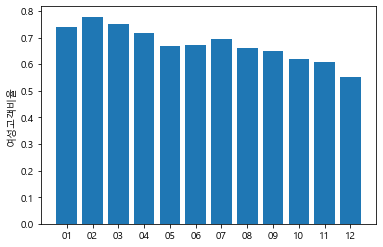

In [13]:
plt.bar(dfcustMons2_s1.month_flag, dfcustMons2_s1.r_Female)
plt.ylabel('여성고객비율')
plt.show()

In [14]:
# 월별 주구매고객 연령평균 집계

dfcustMons2_s2 = dfcustMons2[['month_flag','age']].groupby('month_flag').mean().reset_index()
dfcustMons2_s2

,month_flag,age
0,01,35.212481
1,02,35.573808
2,03,35.205147
3,04,35.231426
4,05,35.677352
5,06,35.455502
6,07,35.980247
7,08,34.925337
8,09,35.330068
9,10,35.290551


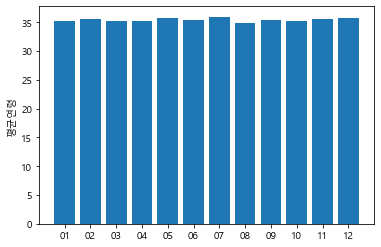

In [15]:
plt.bar(dfcustMons2_s2.month_flag, dfcustMons2_s2.age)
plt.ylabel('평균연령')
plt.show()

- 평균연령에서는 별 차이 없음

In [16]:
# 월별 주구매고객 중 젊은 고객수 비율 집계

dfcustMons21 = dfcustMons2[['month_flag','age']]
# 28세 이하를 젊은 고객으로 설정
dfcustMons21['is_young'] = np.where(dfcustMons21.age<=28,1,0)
dfcustMons2_s3 = dfcustMons21[['month_flag','is_young']].groupby('month_flag').mean().reset_index()
dfcustMons2_s3

,month_flag,is_young
0,01,0.267459
1,02,0.255110
2,03,0.263971
3,04,0.263023
4,05,0.222300
5,06,0.230622
6,07,0.246914
7,08,0.260710
8,09,0.257724
9,10,0.246457


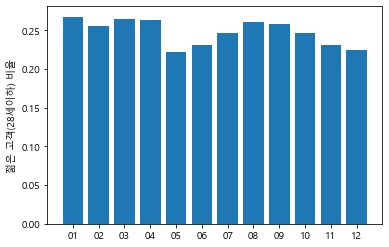

In [17]:
plt.bar(dfcustMons2_s3.month_flag, dfcustMons2_s3.is_young)
plt.ylabel('젊은 고객(28세이하) 비율')
plt.show()

In [18]:
# 월별 주구매고객 중년이상고객수 비율 집계

dfcustMons21 = dfcustMons2[['month_flag','age']]
# 48세 이상을 젊은 고객으로 설정
dfcustMons21['is_48plus'] = np.where(dfcustMons21.age>=48,1,0)
dfcustMons2_s4 = dfcustMons21[['month_flag','is_48plus']].groupby('month_flag').mean().reset_index()
dfcustMons2_s4

,month_flag,is_48plus
0,01,0.106488
1,02,0.118092
2,03,0.101471
3,04,0.103330
4,05,0.111498
5,06,0.096651
6,07,0.127160
7,08,0.099143
8,09,0.107762
9,10,0.103937


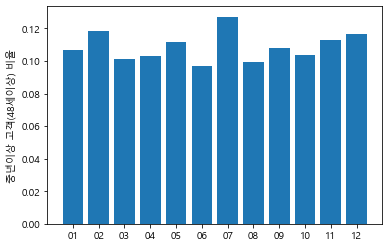

In [19]:
plt.bar(dfcustMons2_s4.month_flag, dfcustMons2_s4.is_48plus)
plt.ylabel('중년이상 고객(48세이상) 비율')
plt.show()

- 2월, 7월, 11~12월 지점에 중년이상 고객 비율 높음
- 단순 평균 비교와는 다른 패턴 파악됨

In [20]:
dfcustMons2_s5 = dfcustMons2_s3.merge(dfcustMons2_s4, how='left', on='month_flag')
dfcustMons2_s5['is_2947'] = 1 - (dfcustMons2_s5.is_young + dfcustMons2_s5.is_48plus)

# 컬럼순서 재정렬
dfcustMons2_s5 = dfcustMons2_s5[['month_flag','is_young', 'is_2947','is_48plus']]
dfcustMons2_s5

,month_flag,is_young,is_2947,is_48plus
0,01,0.267459,0.626053,0.106488
1,02,0.255110,0.626798,0.118092
2,03,0.263971,0.634559,0.101471
3,04,0.263023,0.633646,0.103330
4,05,0.222300,0.666202,0.111498
5,06,0.230622,0.672727,0.096651
6,07,0.246914,0.625926,0.127160
7,08,0.260710,0.640147,0.099143
8,09,0.257724,0.634514,0.107762
9,10,0.246457,0.649606,0.103937


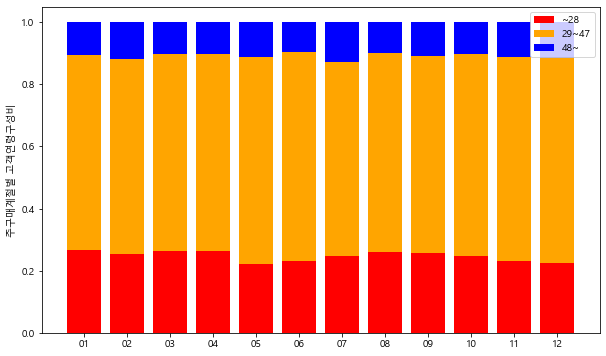

In [21]:
# plot bars in stack manner

plt.figure(figsize=(10,6))
plt.bar(dfcustMons2_s5.month_flag, dfcustMons2_s5.is_young, color='r')
plt.bar(dfcustMons2_s5.month_flag, dfcustMons2_s5.is_2947, 
        bottom=dfcustMons2_s5.is_young, # 직전 막대의 위에 막대가 나타나도록 옵션 지정 
        color='orange')
plt.bar(dfcustMons2_s5.month_flag, dfcustMons2_s5.is_48plus, bottom=dfcustMons2_s5.is_2947+dfcustMons2_s5.is_young, color='b')
plt.legend(['~28', '29~47','48~'])
plt.ylabel('주구매계절별 고객연령구성비')
plt.show()

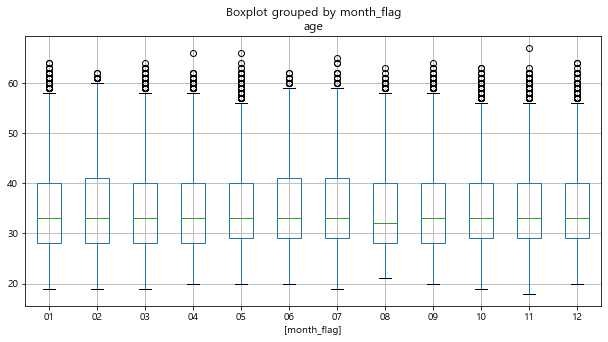

In [22]:
# 계절별 연령구성분포를 박스플롯으로

dfcustMons2[['month_flag','age']].boxplot(by='month_flag', figsize=(10,5))
plt.show()

- 6, 7월 연령 구성이 좀 더 나이 많은 쪽임이 파악됨

### 주구매월과 구매 브랜드간 관계

In [23]:
# 고객별로 주구매브랜드 파악

saless05 = sales[['cust_id','brand_nm','amt']].groupby(['cust_id','brand_nm']).sum().reset_index()
# 금액이 많은 브랜드 부터로 순서 미리 정렬
saless05 = saless05.sort_values(['cust_id','amt'], ascending=[False,False])
# 이미 정렬된 테이블에서 고객별 브랜드 1개 (금액많은) 추출
saless05s1 = saless05[['cust_id','brand_nm']].groupby('cust_id').head(1)
saless05s1.tail(10)

,cust_id,brand_nm
11,B100000070,Shoote
9,B100000055,Shoote
8,B100000049,Shoote
7,B100000043,Shoote
6,B100000038,Shoote
5,B100000037,Shoote
3,B100000023,Esteeme
2,B100000022,Shoote
1,B100000005,Shoote
0,B100000003,Shoote


In [24]:
dfcustMons6 = dfcustMons2.merge(saless05s1, how='left', on='cust_id')
dfcustMons6s1 = pd.crosstab(dfcustMons6.month_flag, dfcustMons6.brand_nm).reset_index()
dfcustMons6s1['r_Esteeme'] = dfcustMons6s1['Esteeme'] / (dfcustMons6s1['Esteeme'] + dfcustMons6s1['Shoote'])
dfcustMons6s1

brand_nm,month_flag,Esteeme,Shoote,r_Esteeme
0,01,306,1713,0.151560
1,02,218,1103,0.165026
2,03,202,1158,0.148529
3,04,184,987,0.157131
4,05,207,1228,0.144251
5,06,133,912,0.127273
6,07,122,688,0.150617
7,08,113,704,0.138311
8,09,207,1120,0.155991
9,10,170,1100,0.133858


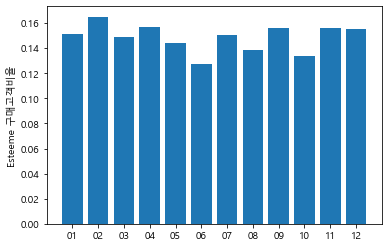

In [25]:
plt.bar(dfcustMons6s1.month_flag, dfcustMons6s1.r_Esteeme)
plt.ylabel('Esteeme 구매고객비율')
plt.show()

- 2월은 구매고객 중 Esteeme 주구매고객의 비율이 높고
- 6월은 연중 가장 낮음

### [예제2] 이용채널에 따라서 고객들에 어떤 특성 차이가 있는가?

In [26]:
# 점포 중 하나로 온라인 존재

sales['store'].value_counts()

ONL                 12310
Multi bupyong       11441
Shoote gasan        10425
Shoote city          5603
Esteeme joongang     2157
Name: store, dtype: int64

In [27]:
# 고객리스트 생성
df_custs = sales[['cust_id']].drop_duplicates()
# 고객번호가 없는 식별되지 않은 고객은 제외
df_custs = df_custs[~df_custs.cust_id.isna()]
print('고객수', len(df_custs))

# 고객별 온라인 채널 이용여부 집계
df_onl_custs = sales[sales.store=='ONL'][['cust_id']].drop_duplicates()
df_onl_custs['is_ONL'] = 1
print('온라인 이용고객수', len(df_onl_custs))

# 고객별 오프라인 채널 이용여부 집계
df_offl_custs = sales[~(sales.store=='ONL')][['cust_id']].drop_duplicates()
df_offl_custs['is_STR'] = 1
print('오프라인 이용고객수', len(df_offl_custs))

# 고객리스트에 온라인, 오프라인 채널 이용여부 컬럼 결합

df_custChnnl = df_custs.merge(df_onl_custs, how='left', on='cust_id')
df_custChnnl = df_custChnnl.merge(df_offl_custs, how='left', on='cust_id')
df_custChnnl.fillna(0, inplace=True)

print('온오프라인 모두 이용고객수', len(df_custChnnl[(df_custChnnl.is_ONL==1) & (df_custChnnl.is_STR==1)]))
df_custChnnl

고객수 15565
온라인 이용고객수 7666
오프라인 이용고객수 11553
온오프라인 모두 이용고객수 3652


,cust_id,is_ONL,is_STR
0,B100048542,1.0,1.0
1,B100026268,0.0,1.0
2,B100009871,0.0,1.0
3,B100051628,0.0,1.0
4,B100075455,0.0,1.0
...,...,...,...
15560,B100024703,1.0,0.0
15561,B100097247,1.0,0.0
15562,B100022944,1.0,0.0
15563,B100064126,0.0,1.0


In [28]:
# 채널 이용 유형을 Both, Store only, Online only 세가지 유형으로 구분

df_custChnnl['chnnl_type'] = np.where((df_custChnnl.is_ONL==1) & (df_custChnnl.is_STR==1), 'BTH','_')
df_custChnnl['chnnl_type'] = np.where((df_custChnnl.is_ONL==0) & (df_custChnnl.is_STR==1), 'STR only',df_custChnnl['chnnl_type'])
df_custChnnl['chnnl_type'] = np.where((df_custChnnl.is_ONL==1) & (df_custChnnl.is_STR==0), 'ONL only',df_custChnnl['chnnl_type'])

df_custChnnl.sample(5)

,cust_id,is_ONL,is_STR,chnnl_type
1628,B100090261,1.0,1.0,BTH
4700,B100053125,1.0,0.0,ONL only
9726,B100090273,1.0,0.0,ONL only
10253,B100051129,1.0,0.0,ONL only
5455,B100094769,1.0,1.0,BTH


In [29]:
# 이용채널 유형별 해당고객수 집계

df_custChnnls0 = df_custChnnl[['cust_id','chnnl_type']].groupby('chnnl_type').count().reset_index()
df_custChnnls0

,chnnl_type,cust_id
0,BTH,3652
1,ONL only,4013
2,STR only,7900


In [30]:
# 연령, 성별, 지역 특성 결합

df_custChnnl1 = df_custChnnl.merge(custmast[['cust_id','age', 'sex', 'area']], how='left', on='cust_id')
df_custChnnl1

,cust_id,is_ONL,is_STR,chnnl_type,age,sex,area
0,B100048542,1.0,1.0,BTH,32,M,inchon
1,B100026268,0.0,1.0,STR only,29,F,gyunggi
2,B100009871,0.0,1.0,STR only,51,M,seoul
3,B100051628,0.0,1.0,STR only,35,F,inchon
4,B100075455,0.0,1.0,STR only,31,M,gyunggi
...,...,...,...,...,...,...,...
15560,B100024703,1.0,0.0,ONL only,31,M,seoul
15561,B100097247,1.0,0.0,ONL only,51,M,inchon
15562,B100022944,1.0,0.0,ONL only,32,M,gangwon
15563,B100064126,0.0,1.0,STR only,32,M,gyunggi


In [31]:
# 이용채널 유형별 평균연령 집계

df_custChnnl1s1 = df_custChnnl1[['chnnl_type','age']].groupby('chnnl_type').mean().reset_index()
df_custChnnl1s1

,chnnl_type,age
0,BTH,35.600767
1,ONL only,36.692001
2,STR only,34.716835


In [32]:
# 이용채널 유형별 여성비율 집계

df_custChnnl1['is_female'] = np.where(df_custChnnl1.sex=='F',1,0)
df_custChnnl1s2 = df_custChnnl1[['chnnl_type','is_female']].groupby('chnnl_type').mean().reset_index()
df_custChnnl1s2

,chnnl_type,is_female
0,BTH,0.873768
1,ONL only,0.645402
2,STR only,0.600127


,chnnl_type,age,is_female,cust_id
0,BTH,35.600767,0.873768,3652
1,ONL only,36.692001,0.645402,4013
2,STR only,34.716835,0.600127,7900


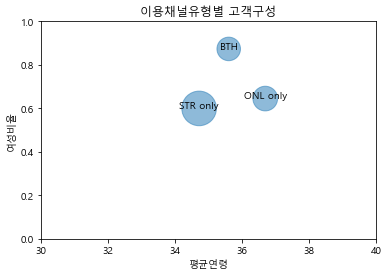

In [33]:
# 각각 집계한 연령, 성비, 고객수 결합해 하나의 테이블 생성 
# 요약된 프로파일(profile) 테이블 생성

df_custChnnl1s3 = df_custChnnl1s1.merge(df_custChnnl1s2, how='left', on='chnnl_type')
df_custChnnl1s3 = df_custChnnl1s3.merge(df_custChnnls0, how='left', on='chnnl_type')

display(df_custChnnl1s3)

# 프로파일 테이블의 시각화 - 산점도 scatter plot
plt.scatter(df_custChnnl1s3.age, df_custChnnl1s3.is_female,
            # 원의 크키를 통해 세번째 프로파일 항목을 표시
           s=df_custChnnl1s3.cust_id/df_custChnnl1s3.cust_id.max()*1200,
           alpha=0.5)
plt.xlabel('평균연령')
plt.ylabel('여성비율')
plt.xlim(30,40)
plt.ylim(0,1)
for i in df_custChnnl1s3.index:
    plt.text(df_custChnnl1s3.age[i], df_custChnnl1s3.is_female[i], 
             df_custChnnl1s3.chnnl_type[i],
            ha='center')
plt.title('이용채널유형별 고객구성')    
plt.show()

- [discussion] 나이가 많은 여성쪽에서 온라인 이용이 많은 이유는?

#### [추가연습문제] 
- 2019년과 2020년 이용채널유형별 고객구성을 각각 산출하여 비교하는 테이블을 생성하고 시각화하라

## 실전적인 판매데이터 고급분석: 상품분석(plus 외부데이터 결합분석)

### [예제 1] 상품 판매가격과 판매량간 관계분석

In [34]:
sales[['item_id','unit_prc']].drop_duplicates()

,item_id,unit_prc
0,SH1003405,80000
1,SH1003602,60000
2,SH1003306,70000
3,SH1008104,60000
4,ES2002609,100000
...,...,...
40439,SH1006102,75000
40447,SH1004001,108000
40463,SH1004801,187000
40478,ES2000803,75000


In [35]:
# 상품코드별 가격이 복수인 경우, 즉 가격이 변동한 경우가 있는가?

len(sales.item_id.unique()) 

# 상품코드수 보다 상품별가격별 건수가 많다면 가격이 변동한적이 있다는 것

958

<AxesSubplot:>

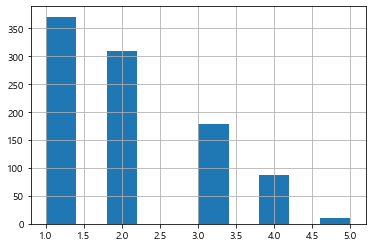

In [36]:
# 상품별 판매된 가격의 종류 수는?

sales[['item_id','unit_prc']].drop_duplicates().groupby('item_id').count().reset_index().unit_prc.hist()

In [37]:
# 판매된 가격이 5개인 상품은? 각 상품의 판매된 가격 내역은?

dfprdprc1 = sales[['item_id','unit_prc']].drop_duplicates().groupby('item_id').count().reset_index()
display(dfprdprc1[dfprdprc1.unit_prc==5])

sales[sales.item_id.isin(dfprdprc1[dfprdprc1.unit_prc==5].item_id)][['item_id','unit_prc']].drop_duplicates().sort_values(['item_id','unit_prc']).tail(20)

,item_id,unit_prc
15,ES2000701,5
379,SH1000806,5
437,SH1001607,5
507,SH1002702,5
584,SH1003804,5
585,SH1003805,5
596,SH1004001,5
641,SH1004504,5
710,SH1005504,5
723,SH1005705,5


,item_id,unit_prc
40294,SH1004504,108000
8310,SH1004504,116000
16033,SH1004504,123000
3311,SH1004504,135000
73,SH1004504,145000
40427,SH1005504,82000
32822,SH1005504,88000
16123,SH1005504,93000
3314,SH1005504,100000
135,SH1005504,110000


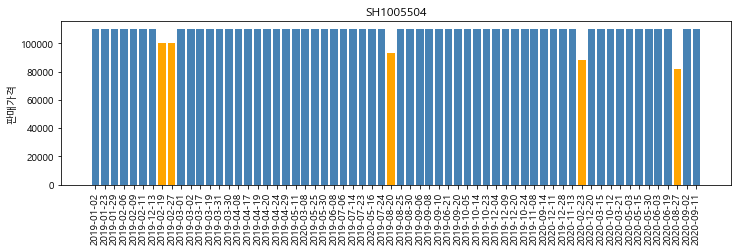

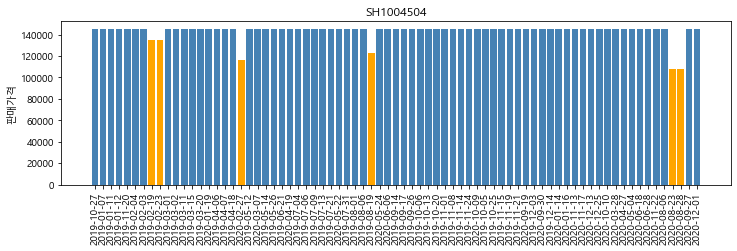

In [38]:
# 가격이 변동된 특정 상품들의 가격 변동 추이 확인

# 루프를 사용해 한 번에 여러 챠트 생성

for x in ['SH1005504', 'SH1004504']:
    colors1 = np.where(sales[sales.item_id==x].unit_prc<sales[sales.item_id==x].unit_prc.max(), 
                       'orange','steelblue')
    plt.figure(figsize=(12,3))
    plt.bar(sales[sales.item_id==x].datea,
            sales[sales.item_id==x].unit_prc, 
            color=colors1)
    plt.xticks(rotation=90)
    plt.title(x)
    plt.ylabel('판매가격')
    plt.show()

# 4번의 행사에서 각각 가격을 일시 인하했던 것

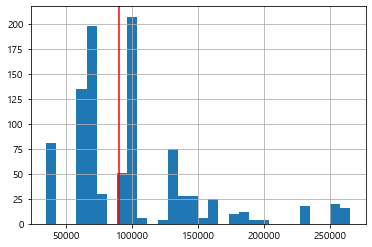

In [39]:
# 상품별로 판매된 가격 중 가장 높은 가격(실질적인 정상가)의 분포는?

series =sales[['item_id','unit_prc']].drop_duplicates().groupby('item_id').max().reset_index().unit_prc
series.hist(bins=30)
plt.axvline(series.median(), color='red')
plt.show()

In [40]:
# 가격과 판매량 간의 관계는?

sales[['item_id','unit_prc', 'qty']].groupby(['item_id','unit_prc']).sum().reset_index()

,item_id,unit_prc,qty
0,ES2000501,131000,2
1,ES2000501,155000,96
2,ES2000502,131000,1
3,ES2000502,145000,4
4,ES2000502,155000,127
...,...,...,...
1928,SH1009002,60000,145
1929,SH1009003,60000,103
1930,SH1009004,60000,161
1931,SH1009005,60000,189


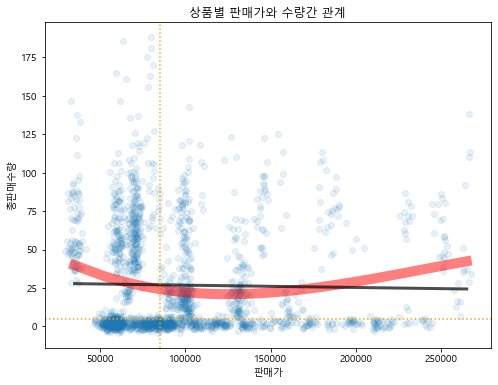

In [41]:
dftmp = sales[['item_id','unit_prc', 'qty']].groupby(['item_id','unit_prc']).sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(rjitt(dftmp.unit_prc), rjitt(dftmp.qty), alpha=0.1)
# 다항 추세선 추가
varx = dftmp.unit_prc
vary = dftmp.qty
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
         color='red', linewidth=10, alpha=0.5)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='k', linewidth=3, alpha=0.7)
plt.xlabel('판매가')
plt.ylabel('총판매수량')
plt.title('상품별 판매가와 수량간 관계')
plt.axvline(varx.median(), linestyle=':', color='orange')
plt.axhline(vary.median(), linestyle=':', color='orange')
plt.show()

- 판매량이 많은 상품은 소수
- 전체적으로는 판매가가 높을수록 판매량이 적은 것으로 보이지만 **(black line)**
- 판매가가 12만원 이상이 상품들에서는 가격이 높을수록 판매량이 많은 패턴 **(red line)** 

#### 개별상품의 가격할인과 판매량 변화 관점의 분석

In [42]:
# 상품별 가격별 판매수량 합계와 판매일수 집계

# 상품별 가격별 판매수량 합계 집계
dftmppp1 = sales[['item_id','unit_prc', 'qty']].groupby(['item_id','unit_prc']).sum().reset_index()

# 상품별 가격별 판매일수 집계
dftmppp2 = sales[['item_id','unit_prc', 'datea']].drop_duplicates().groupby(['item_id','unit_prc']).count().reset_index()

# 테이블 결합
dftmppp3 = dftmppp1.merge(dftmppp2, how='left', on=['item_id', 'unit_prc'])
dftmppp3

,item_id,unit_prc,qty,datea
0,ES2000501,131000,2,2
1,ES2000501,155000,96,65
2,ES2000502,131000,1,1
3,ES2000502,145000,4,3
4,ES2000502,155000,127,96
...,...,...,...,...
1928,SH1009002,60000,145,103
1929,SH1009003,60000,103,75
1930,SH1009004,60000,161,107
1931,SH1009005,60000,189,133


In [43]:
# 상품별 최고가 (=정상가) 집계
dftmppp4 = dftmp[['item_id','unit_prc']].groupby('item_id').max().reset_index()
dftmppp4.columns = ['item_id', 'max_prc']

# 상품별 최고가 결합 후 
dftmppp5 = dftmppp3.merge(dftmppp4, how='left', on='item_id')

# 최고가에서 할인한 비율 계산
dftmppp5['dc_rate'] = (dftmppp5.max_prc - dftmppp5.unit_prc) / dftmppp5.max_prc
dftmppp5['daily_qty'] = dftmppp5.qty / dftmppp5.datea
dftmppp5

# 일판매량 최대값 계산
dftmppp6 = dftmppp5[['item_id', 'daily_qty']].groupby('item_id').mean().reset_index()
dftmppp6.columns = ['item_id', 'mean_daily_qty']
dftmppp7 = dftmppp5.merge(dftmppp6, how='left', on='item_id')
dftmppp7['lift_sale_qty'] = dftmppp7.daily_qty / dftmppp7.mean_daily_qty
dftmppp7

,item_id,unit_prc,qty,datea,max_prc,dc_rate,daily_qty,mean_daily_qty,lift_sale_qty
0,ES2000501,131000,2,2,155000,0.154839,1.000000,1.238462,0.807453
1,ES2000501,155000,96,65,155000,0.000000,1.476923,1.238462,1.192547
2,ES2000502,131000,1,1,155000,0.154839,1.000000,1.218750,0.820513
3,ES2000502,145000,4,3,155000,0.064516,1.333333,1.218750,1.094017
4,ES2000502,155000,127,96,155000,0.000000,1.322917,1.218750,1.085470
...,...,...,...,...,...,...,...,...,...
1928,SH1009002,60000,145,103,60000,0.000000,1.407767,1.407767,1.000000
1929,SH1009003,60000,103,75,60000,0.000000,1.373333,1.373333,1.000000
1930,SH1009004,60000,161,107,60000,0.000000,1.504673,1.504673,1.000000
1931,SH1009005,60000,189,133,60000,0.000000,1.421053,1.421053,1.000000


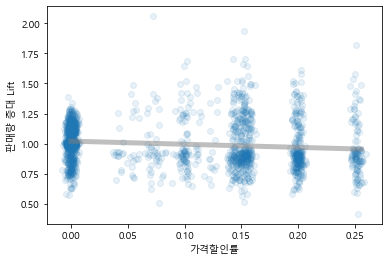

-0.12723435330954305

In [44]:
# 전체 상품에서의 각 상품별 가격할인률과 판매량 증대(lift)간의 관계

plt.scatter(rjitt(dftmppp7.dc_rate), rjitt(dftmppp7.lift_sale_qty),
           alpha=0.1)
varx = dftmppp7.dc_rate
vary = dftmppp7.lift_sale_qty
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='grey', linewidth=5, alpha=0.5)
plt.xlabel('가격할인률')
plt.ylabel('판매량 증대 Lift')
plt.show()

np.corrcoef(varx, vary)[0,1]

- [의미 검토] 가격할인률이 크면 판매량은 평균적인 하루 판매량 보다 오히려 줄어든다?
- 제철이 지나서 할인 행사를 하기 때문에 할인 행사하는 시기에서는 판매량이 늘어나지는 않는다?
<br><br>
- **각 상품별로 따로 검토해야만 의미있는 것은 아닌가?**

분석대상 상품 :  ['ES2000502' 'SH1003704' 'SH1003304']


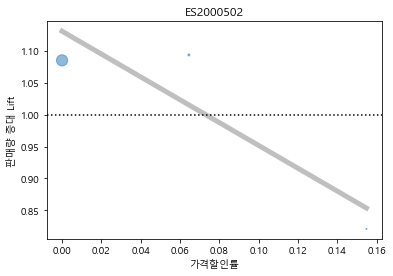

-0.8981928881142334


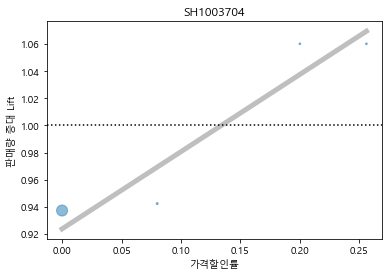

0.946757011730531


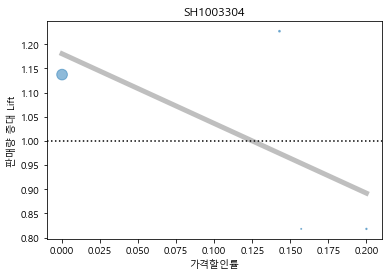

-0.5866694980626845


In [45]:
# 판매량 Top 일부 상품 각각에 대한 각 상품별 가격할인률과 판매량 증대(lift)간의 관계

# 대상 상품 선정
prds2chk = sales[['item_id', 'qty']].groupby('item_id').sum().reset_index().nlargest(30, 'qty').item_id
# 할인한 적 있는 상품 중에서만 선정 필요
prds2chk = dftmppp7[(dftmppp7.dc_rate>0) & (dftmppp7.item_id.isin(prds2chk))].sample(3).item_id.unique()
print('분석대상 상품 : ', prds2chk)

for x in prds2chk: 
    plt.scatter(dftmppp7[dftmppp7.item_id==x].dc_rate, 
                dftmppp7[dftmppp7.item_id==x].lift_sale_qty,
                alpha=0.5,
                s=dftmppp7[dftmppp7.item_id==x].qty # 일평균판매량
               )
    varx = dftmppp7[dftmppp7.item_id==x].dc_rate
    vary = dftmppp7[dftmppp7.item_id==x].lift_sale_qty
    plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
             color='grey', linewidth=5, alpha=0.5)
    plt.axhline(1, color='k', linestyle=':')
    plt.xlabel('가격할인률')
    plt.ylabel('판매량 증대 Lift')
    plt.title(x)
    plt.show()

    print(np.corrcoef(varx, vary)[0,1])

- 주요 상품에서 가격할인 기간이 길지 않았기 때문에 할인가에 판매된 수량 비중 작음
- 주요 상품 중 대부분이 가격할인한 기간에 정상판매 기간에서의 할인보다 일평균 판매량이 많지 않았음
<br><br>
- 가격할인의 진정한 효과를 파악하려면 할인한 행사 기간에 대한 판매량 추정치(**baseline sales**)를 구하는 방식 필요

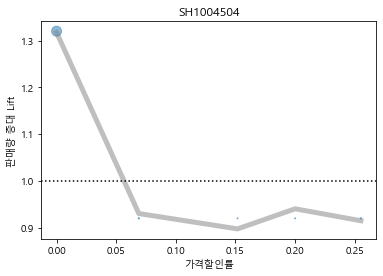

-0.741573521115353


In [46]:
prds2chk= ['SH1004504']

for x in prds2chk: 
    plt.scatter(dftmppp7[dftmppp7.item_id==x].dc_rate, 
                dftmppp7[dftmppp7.item_id==x].lift_sale_qty,
                alpha=0.5,
               s=dftmppp7[dftmppp7.item_id==x].qty)
    varx = dftmppp7[dftmppp7.item_id==x].dc_rate
    vary = dftmppp7[dftmppp7.item_id==x].lift_sale_qty
    plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
             color='grey', linewidth=5, alpha=0.5)
    plt.axhline(1, color='k', linestyle=':')
    plt.xlabel('가격할인률')
    plt.ylabel('판매량 증대 Lift')
    plt.title(x)
    plt.show()

    print(np.corrcoef(varx, vary)[0,1])

- SH1004504 는 할인한 가격이 여러 가지 였던 경우 (할인률은 변동 가능)
- 판매가 부진할수록 큰 폭으로 할인하는 구조라면 할인이 클수록 판매량은 낮은 관계(bias) 가능
- **할인 때문에 판매가 줄어든 것이 아니라** 판매가 줄어서 할인을 시도했던 것

In [47]:
# 할인 기간이 가장 여러 날이었던 상품은 무엇인가?
# 상품별 판매된 날 수 와 그 중 최고가가 아니었던 날 의 수 비교

# 상품별 가격별 판매일수 집계 (할인여부 무관)
df_itemSaleDays = sales[['datea', 'item_id', 'unit_prc']].groupby(['item_id', 'unit_prc']).count().reset_index()
display(df_itemSaleDays.head())

# 상품별 최고가 파악
df_itemMaxPriceDays = sales[['item_id', 'unit_prc']].groupby('item_id').max().reset_index()
df_itemMaxPriceDays.columns = ['item_id', 'max_price']
display(df_itemMaxPriceDays.head())

# 최고가를 결합한 후 판매단가가 최고가보다 작은 금액인지를 체크
df_itemSaleDays = df_itemSaleDays.merge(df_itemMaxPriceDays, how='left', on='item_id')
df_itemSaleDays['is_DC'] = np.where(df_itemSaleDays.unit_prc<df_itemSaleDays.max_price,1,0)
display(df_itemSaleDays.head())

# 판매단가가 최고가와 다른 즉 가격할인이 있었던 날의 수를 집계
df_itemDCdayStat = df_itemSaleDays[['item_id', 'is_DC','datea']].groupby(['item_id', 'is_DC']).sum().reset_index()
display(df_itemDCdayStat.head())

# 할인인 일수와 할인 없는 일수를 비교 가능하도록 pivot
df_itemDCdayStat1 = df_itemDCdayStat.pivot(index='item_id', columns ='is_DC', values='datea').reset_index()
display(df_itemDCdayStat1.head())

# 할인이 있는 일자의 수가 7이상으로 많은 상품만 추출
df_itemDCdayStat1[df_itemDCdayStat1[1]>=8]

,item_id,unit_prc,datea
0,ES2000501,131000,2
1,ES2000501,155000,74
2,ES2000502,131000,1
3,ES2000502,145000,3
4,ES2000502,155000,109


,item_id,max_price
0,ES2000501,155000
1,ES2000502,155000
2,ES2000503,155000
3,ES2000504,155000
4,ES2000505,155000


,item_id,unit_prc,datea,max_price,is_DC
0,ES2000501,131000,2,155000,1
1,ES2000501,155000,74,155000,0
2,ES2000502,131000,1,155000,1
3,ES2000502,145000,3,155000,1
4,ES2000502,155000,109,155000,0


,item_id,is_DC,datea
0,ES2000501,0,74
1,ES2000501,1,2
2,ES2000502,0,109
3,ES2000502,1,4
4,ES2000503,0,55


is_DC,item_id,0,1
0,ES2000501,74.0,2.0
1,ES2000502,109.0,4.0
2,ES2000503,55.0,3.0
3,ES2000504,90.0,8.0
4,ES2000505,62.0,2.0


is_DC,item_id,0,1
3,ES2000504,90.0,8.0
386,SH1001001,61.0,10.0
391,SH1001006,64.0,10.0
401,SH1001201,54.0,8.0
437,SH1001607,52.0,10.0
446,SH1001707,46.0,8.0
464,SH1002006,70.0,9.0
465,SH1002101,74.0,8.0
504,SH1002603,56.0,8.0
562,SH1003501,84.0,9.0


In [48]:
items_DC = df_itemDCdayStat1[df_itemDCdayStat1[1]>=8].item_id

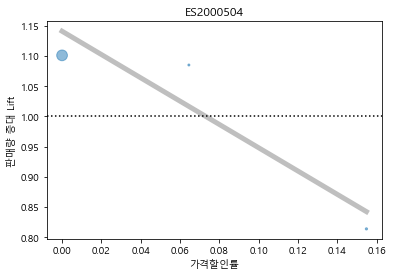

-0.9293225697751466


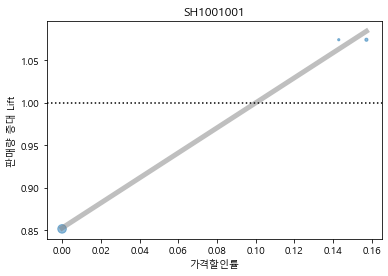

0.9966158955401239


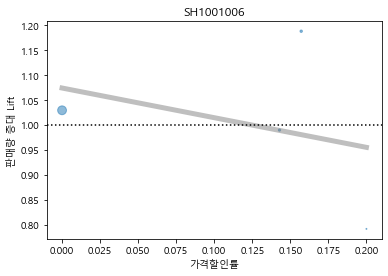

-0.31679164802624193


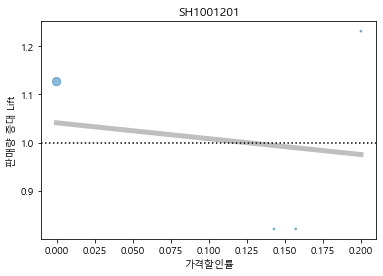

-0.1354048336327882


In [49]:
# 할인 기간이 긴 편이었던 상품 각각에 대한 각 상품별 가격할인률과 판매량 증대(lift)간의 관계

# 대상 상품 지정
prds2chk = items_DC[:4]

for x in prds2chk: 
    plt.scatter(dftmppp7[dftmppp7.item_id==x].dc_rate, 
                dftmppp7[dftmppp7.item_id==x].lift_sale_qty,
                alpha=0.5,
                s=dftmppp7[dftmppp7.item_id==x].qty # 일평균판매량
               )
    varx = dftmppp7[dftmppp7.item_id==x].dc_rate
    vary = dftmppp7[dftmppp7.item_id==x].lift_sale_qty
    plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
             color='grey', linewidth=5, alpha=0.5)
    plt.axhline(1, color='k', linestyle=':')
    plt.xlabel('가격할인률')
    plt.ylabel('판매량 증대 Lift')
    plt.title(x)
    plt.show()

    print(np.corrcoef(varx, vary)[0,1])

### [예제 2] 상품군의 판매 추이와 시장 동향간 관계 - 외부데이터 결합 분석

In [50]:
# 상품군 리스트 확인

sales[['lcat','scat']].drop_duplicates()

,lcat,scat
0,남성캐주얼,셔츠
1,여성캐주얼,바지
3,여성캐주얼,셔츠
7,여성캐주얼,재킷
17,여성캐주얼,치마
21,남성캐주얼,바지
50,코트,코트
73,남성캐주얼,재킷


In [51]:
# 값별 인원수와 구성비를 dataframe 형태로 출력하는 사용자 정의 함수
# 건수 집계와 구성비 계산 작업의 반복적 과정을 한번에 처리해
# 편의성을 높이기 위한 방법

def cntnpcnt(x):
    # x is supposed to be a pandas series
    dfx = pd.DataFrame(x)
    # 한 줄은 한 건의 빈도
    dfx['recCnt'] = 1
    dfx = dfx.groupby(dfx.columns[0]).count().reset_index()
    # 빈도로부터 구성비 계산. 100 곱해서 백분율 단위로
    dfx['pcntrecCnt'] = dfx.recCnt/dfx.recCnt.sum() *100
    return(dfx)

In [52]:
# 상품군별 판매건수 빈도 집계

# 대분류
display(cntnpcnt(sales.lcat))

# 소분류
cntnpcnt(sales.scat)

,lcat,recCnt,pcntrecCnt
0,남성캐주얼,10175,24.263163
1,여성캐주얼,29650,70.702976
2,코트,2111,5.033861


,scat,recCnt,pcntrecCnt
0,바지,18924,45.125906
1,셔츠,13244,31.581457
2,재킷,3959,9.440576
3,치마,3698,8.818199
4,코트,2111,5.033861


In [53]:
# 대분류별 소분류 까지를 기준으로 건수 집계

cntnpcnt(sales.lcat + '_' + sales.scat).sort_values('recCnt', ascending=False)

,0,recCnt,pcntrecCnt
3,여성캐주얼_바지,15565,37.116082
4,여성캐주얼_셔츠,8418,20.073445
1,남성캐주얼_셔츠,4826,11.508012
6,여성캐주얼_치마,3698,8.818199
0,남성캐주얼_바지,3359,8.009824
7,코트_코트,2111,5.033861
2,남성캐주얼_재킷,1990,4.745326
5,여성캐주얼_재킷,1969,4.695250


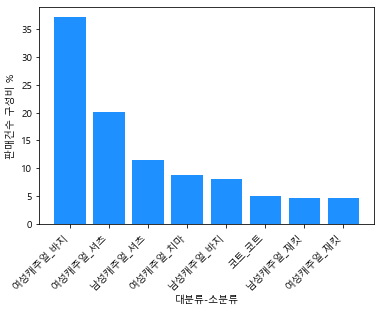

In [54]:
# 대분류별 소분류의 판매건수를 사용자정의함수로 집계한 결과를 데이터프레임으로 저장한 후
# 시각화

# 집계결과를 테이블로 저장
dfprdCatFreq = cntnpcnt(sales.lcat + '_' + sales.scat)
dfprdCatFreq = dfprdCatFreq.sort_values('recCnt', ascending=False)

# 저장한 결과 테이블을 시각화
plt.bar(dfprdCatFreq[0], dfprdCatFreq.pcntrecCnt,
       color = 'dodgerblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('대분류-소분류')
plt.ylabel('판매건수 구성비 %')
plt.show()

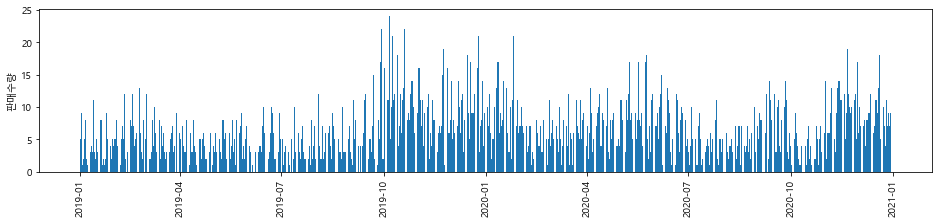

In [55]:
# 특정 품목 또는 관심 품목 (분류)의 판매 추이 분석

# 여성캐주얼.치마 상품군의 일자별 매출 수량 집계
dfcatsales1 = sales[(sales.lcat=='여성캐주얼') &(sales.scat=='치마')][['datea','qty']].groupby('datea').sum().reset_index()

plt.figure(figsize=(16,3))
plt.bar(pd.to_datetime(dfcatsales1.datea, format='%Y-%m-%d'), # x축에 하루 단위로 표시할 필요 없기에 datetime 형식으로
        dfcatsales1.qty)
plt.ylabel('판매수량')
plt.xticks(rotation=90)
plt.show()

,date,gt_ladies_skirt
30,2019-08-04,21
35,2019-09-08,0
46,2019-11-24,0
47,2019-12-01,37
52,2020-01-05,17
67,2020-04-19,0
68,2020-04-26,29
76,2020-06-21,14
87,2020-09-06,13
89,2020-09-20,41


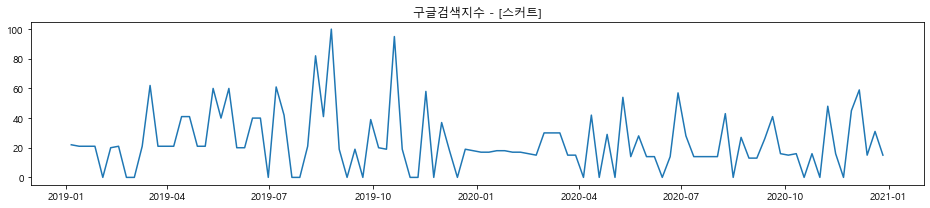

In [56]:
# 소비자 관심을 반영하는 구글검색지수 추출 ( https://trends.google.com/ )
# 검색은 소비자의 해당 개체에 대한 관심도를 대변

# [여성 치마] 키워드 조회결과를 CSV 파일로 다운로드한 후
# 불러들임

df_gt1 = pd.read_csv(dataPath + 'gt_ladiesSkirt.csv')
display(df_gt1.sample(10).sort_values('date'))

plt.figure(figsize=(16,3))
plt.plot(pd.to_datetime(df_gt1.date, format='%Y-%m-%d'), df_gt1.gt_ladies_skirt)
# plt.xticks(rotation=90) # datetime 형식이면 rotation 필요 없음
plt.title('구글검색지수 - [스커트]')
plt.show()

- **구글검색지수**는 대상기간 중 최대값을 100으로 지수화해 놓은 것
- [ <1 ] 즉, 1보다 작으나 0은 아님 부분이 있으면 수치로 바꿔줘야함
- 0과 1 사이의 값이므로 대략 0.5 정도로 바꿔주면 무방할 듯
- 구글지수는 int 형식이므로 0.5가 들어가게되면 float으로 변경 필요

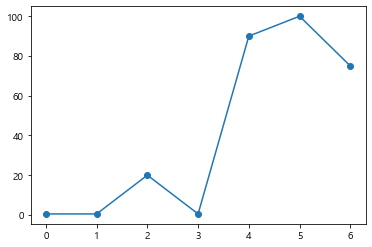

In [57]:
# [ <1 ] 부분 바꾸기 예제

# 예제 데이터 -- <1 값이 여러 개 존재하는 리스트
sampleIndexValues = ['<1', '<1', '20','<1', '90', '100','75']

# 문자열의 값을 0.5 로 바꿔주고
sampleIndexValues = pd.Series(sampleIndexValues).str.replace('<1', '0.5')
# 형식을 숫자 float로 변경
sampleIndexValues = sampleIndexValues.astype(float)

# 변경 결과의 시각화 확인
sampleIndexValues.plot(marker='o')
plt.show()

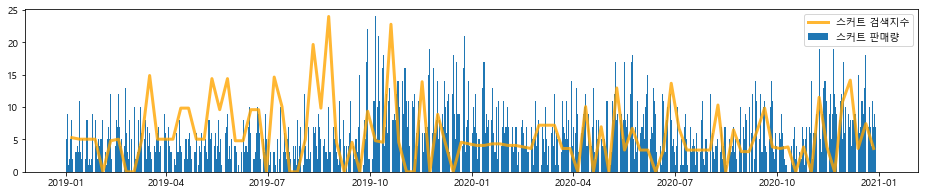

In [58]:
# 스커트 판매량과 검색지수를 하나의 챠트에 시각화

plt.figure(figsize=(16,3))
plt.bar(pd.to_datetime(dfcatsales1.datea, format='%Y-%m-%d'), dfcatsales1.qty)

# zrmx_scl() 로 변환하면 0~1 범위
# 판매량 중 최대값을 곱해주면 판매량과 검색지수가 같은 scale 범위로 나타남
plt.plot(pd.to_datetime(df_gt1.date, format='%Y-%m-%d'), zrmx_scl(df_gt1.gt_ladies_skirt)*dfcatsales1.qty.max() , 
         alpha=0.8, linewidth=3, color='orange')

# <주의!!> bar 와 plot을 겹쳐 그리는 경우 plot이 먼저 나타나 순서 바뀜
# 순서를 반대로 수정해서 지정 필요
plt.legend(['스커트 검색지수','스커트 판매량'])
plt.show()

- 구글검색지수는 주간단위로 제공되므로 일자별 판매량과 결합하기 위해서는 기간단위 일치 필요
- datetime 형식일 경우에는 일자 자동일치되어 챠트에 표시됨

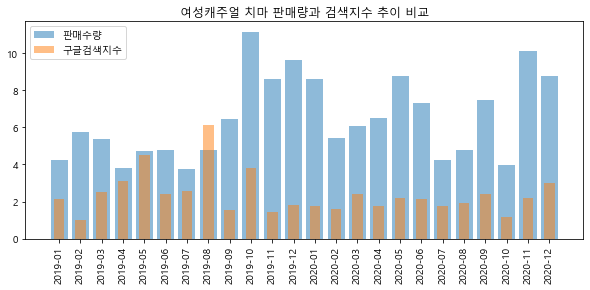

-0.05810358521135683

In [59]:
# 월단위로 기간을 통일해서 비교

df_gt1['datea'] =  pd.to_datetime(df_gt1.date, format='%Y-%m-%d').astype(str)

dfcatsales2 = dfcatsales1.merge(df_gt1, how='left', on='datea')[['datea', 'qty', 'gt_ladies_skirt']]
dfcatsales2['dateMon'] = dfcatsales2.datea.str.slice(0,7)
# 월평균으로 집계
dfcatsales2 = dfcatsales2[['dateMon','qty','gt_ladies_skirt']].groupby('dateMon').mean().reset_index()

plt.figure(figsize=(10,4))
plt.bar(dfcatsales2.dateMon, dfcatsales2.qty, alpha=0.5)

# 스케일이 중요하지 않을 경우에는 시각적으로 차이 패턴이 보일 정도로 일정수를 곱해서 표시해도 무방
plt.bar(dfcatsales2.dateMon, dfcatsales2.gt_ladies_skirt/10, alpha=0.5, width=0.5)
plt.xticks(rotation=90)
plt.legend(['판매수량', '구글검색지수'])
plt.title('여성캐주얼 치마 판매량과 검색지수 추이 비교')
plt.show()

# 두 변수간 상관관계 확인
np.corrcoef(dfcatsales2.qty, dfcatsales2.gt_ladies_skirt)[0,1] 

[**실전적 discussion**] 
- 당사의 판매량과 구글검색간에 (상당히 약하지만) 음의 방향 관계가 나타나는 이유는? 
- 계절성 때문인가? (연말 인근에 판매량이 많았기 때문?)
- 시차의 문제인가? (검색 증가 후 일정기간 지나고 판매 증가하는 패턴?)
- 당사가 시장의 변화와 다른 패턴을 보이고 있는 것인가? (시장 전체적으로는 어떤가?)
<br><br>
- **<font color='blue'>실제로는 가상 데이터라서 나타난 한계?</font>**

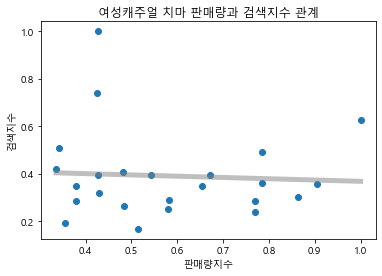

In [60]:
# zero-max scale (zrmx_scl) 함수는 최대값으로 나눈 값으로 원래값의 척도 변경
# X, Y 두축을 비교하기 용이하도록 변경하는 것

plt.scatter(zrmx_scl(dfcatsales2.qty), zrmx_scl(dfcatsales2.gt_ladies_skirt))
plt.xlabel('판매량지수')
plt.ylabel('검색지수')
plt.title('여성캐주얼 치마 판매량과 검색지수 관계')
varx = zrmx_scl(dfcatsales2.qty)
vary = zrmx_scl(dfcatsales2.gt_ladies_skirt)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='grey', linewidth=5, alpha=0.5)
plt.show()

- 2020 판매가 감소하는 패턴은 검색지수 감소와 같은 방향
- 5, 8, 10월 등 야외활동하기 좋은 계절에 적합한 상품을 전개하지 않았기 때문인가?
- 또는 당사의 겨울 스커트가 인기를 끌었기 때문인가?

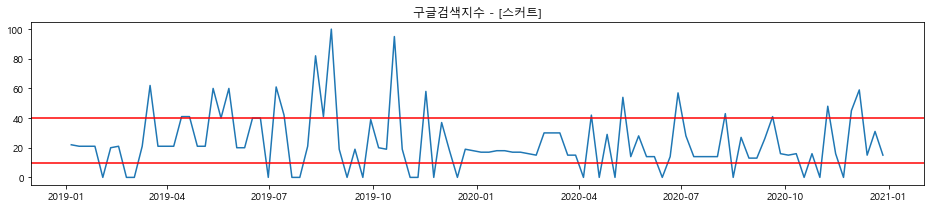

In [61]:
# 특이값들이 영향을 준 것인지 추가 검토
# 특이값 : 소수의 매우 큰 값들

plt.figure(figsize=(16,3))
plt.plot(pd.to_datetime(df_gt1.date, format='%Y-%m-%d'), df_gt1.gt_ladies_skirt)

plt.title('구글검색지수 - [스커트]')
plt.axhline(40, color='red')
plt.axhline(10, color='red')
plt.show()

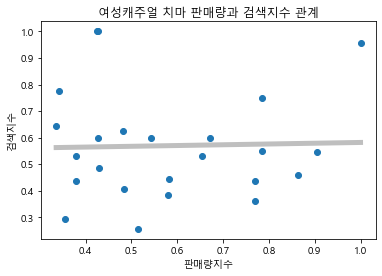

0.028055591077024884

In [62]:
# 혹시 검색지수 중 매우 큰 값이 외부 환경의 일시적 특이 사항 때문에 발생한 일인가?

# 너무 큰 값들 일부를 임의로 조절후 관계 확인
adjSeries = np.where(dfcatsales2.gt_ladies_skirt>40,40, dfcatsales2.gt_ladies_skirt)

# 매우 작은 값들을 임의로 조절후 관계 확인
adjSeries = np.where(adjSeries<10,10, adjSeries)

plt.scatter(zrmx_scl(dfcatsales2.qty), zrmx_scl(adjSeries))
plt.xlabel('판매량지수')
plt.ylabel('검색지수')
plt.title('여성캐주얼 치마 판매량과 검색지수 관계')

varx = zrmx_scl(dfcatsales2.qty)
vary = zrmx_scl(adjSeries)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='grey', linewidth=5, alpha=0.5)
plt.show()

np.corrcoef(varx, vary)[0,1]

- [참고] 실제로는? 

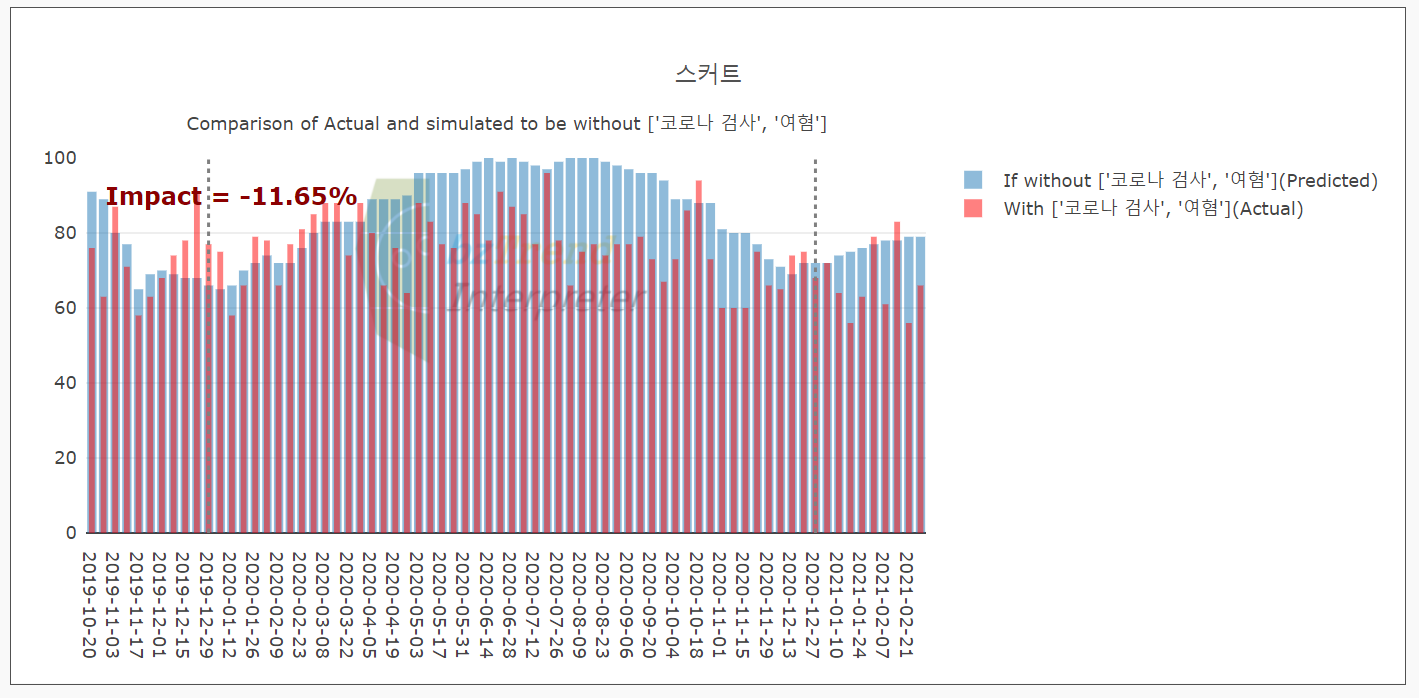

- 통상적인 스커트 시즌은 봄 (3~6월)
- 가상의 기업 Brookline의 스커트는 시장의 통상적인 스커트와는 많이 다른 특성?

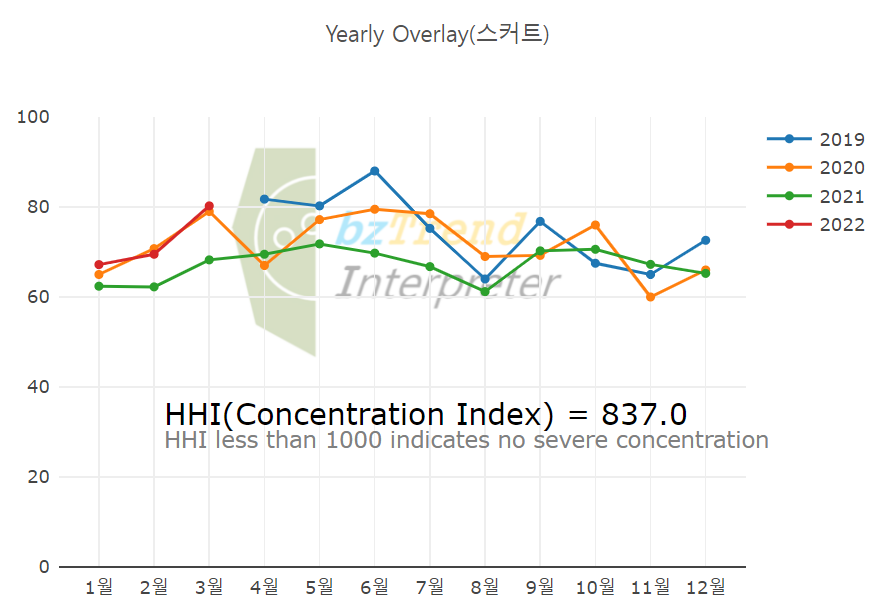

- 개별 구글검색지수 추이 비교

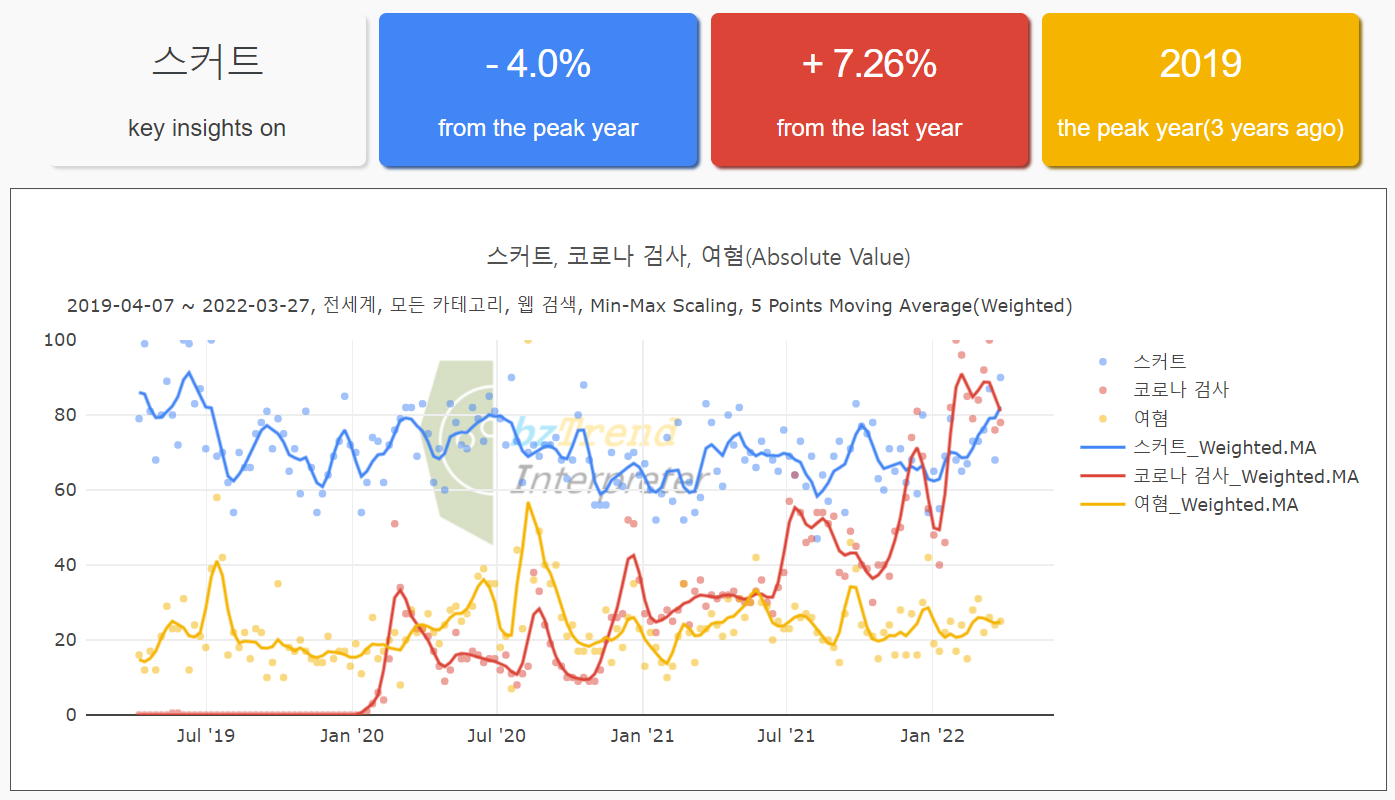

- 시장전체적으로는 2020년 스커트에 대한 검색(관심도) 감소와 동시에 판매량도 감소하는 추세였을 것 (양의 상관관계)
- 시장의 관심이 줄어든 원인 중 일부는 **젠더 갈등**과 코로나로 인한 **외부활동 감소**로 추측됨

## 추가 연습 과제
- 판매비중이 가장 높은 여성캐주얼 바지와 여성캐주얼 셔츠 두 개 상품군의 매출 추이를 비교하고
- 이들의 판매량 변화 원인을 설명하는 외부 데이터 (네이버, 구글, 외부 통계)를 확보하고 결합해 분석하라